In [1]:
import os
os.chdir('../')

%load_ext autoreload
%autoreload 2

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.mingpt import GPT
from torchinfo import summary
from prior import VQVAEPrior
from easydict import EasyDict as edict
from datamodules import get_datasets

from analysis.image import show_image


# General Testing

In [6]:
vocab_size = 32 # Codebook Size
block_size = 8  # Num of tokens representing a single sample

model = GPT(
    vocab_size=vocab_size,
    block_size=block_size,
)
_ = model.eval()
_ = model.to("cuda")

In [13]:
x_2d = torch.randint(0, vocab_size, (1, 2, 2)).cuda()
x_flat = torch.randint(0, vocab_size, (1, 0)).cuda()
with torch.no_grad():
    y = model(x_flat, flattened_input=True)

y.shape

torch.Size([1, 0, 32])

In [15]:
y.squeeze()

tensor([], device='cuda:0', size=(0, 32))

In [15]:
summary(model, input=x, device="cuda")

Layer (type:depth-idx)                        Param #
GPT                                           4,096
├─Embedding: 1-1                              131,072
├─Dropout: 1-2                                --
├─Sequential: 1-3                             --
│    └─Block: 2-1                             --
│    │    └─LayerNorm: 3-1                    512
│    │    └─LayerNorm: 3-2                    512
│    │    └─CausalSelfAttention: 3-3          263,168
│    │    └─Sequential: 3-4                   525,568
│    └─Block: 2-2                             --
│    │    └─LayerNorm: 3-5                    512
│    │    └─LayerNorm: 3-6                    512
│    │    └─CausalSelfAttention: 3-7          263,168
│    │    └─Sequential: 3-8                   525,568
│    └─Block: 2-3                             --
│    │    └─LayerNorm: 3-9                    512
│    │    └─LayerNorm: 3-10                   512
│    │    └─CausalSelfAttention: 3-11         263,168
│    │    └─Sequential: 3

In [5]:
x = torch.zeros((5, 0), dtype=torch.long, device='cuda')

x.shape

torch.Size([5, 0])

# Datasets

In [38]:
DATASETS = get_datasets(
    root='/home/nazir/datasets',
    # transforms=edict(
    #     CIFAR10=T.Compose([
    #         T.ToTensor(),
    #         T.Resize((224, 224)),
    #         T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    #     ]),
    #     CELEBA=T.Compose([
    #         T.ToTensor(),
    #         T.Resize((224, 224)),
    #         T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    #     ]),
    #     OMNIGLOT=T.Compose([
    #         T.ToTensor(),
    #         T.Lambda(lambda x: x.repeat(3, 1, 1)),
    #         T.Resize((224, 224)),
    #         T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    #     ]),
    # )
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /home/nazir/datasets/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


# Examine Trained Prior

In [18]:
ckpt_path = "model_logs/prior/gpt/CIFAR10/gpt_codebook_512_32/epoch=59-val_loss_epoch=0.19.ckpt"
ckpt = torch.load(ckpt_path, map_location="cuda")
prior_hparams = edict(ckpt["hyper_parameters"])
prior = VQVAEPrior(prior_hparams)
prior.load_state_dict(ckpt["state_dict"])

_ = prior.cuda()
_ = prior.eval()

<All keys matched successfully>

In [20]:
samples = prior.generate_samples(batch_size=40)

In [27]:
samples.max(), samples.min()

(tensor(0.6684, device='cuda:0'), tensor(-0.7536, device='cuda:0'))

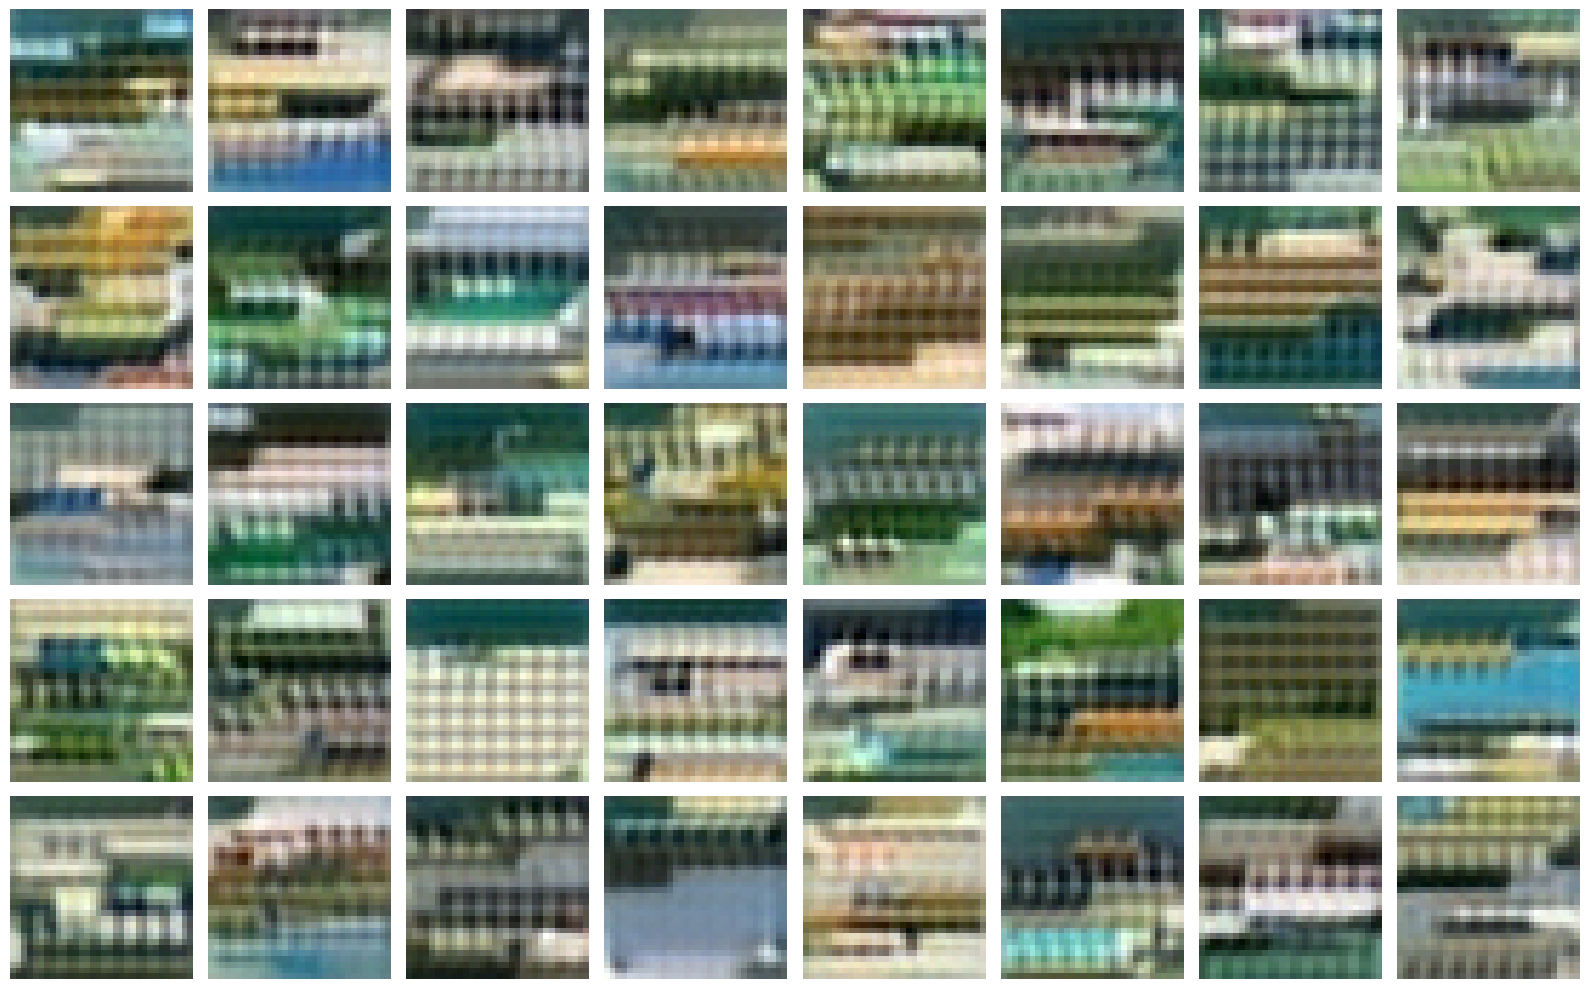

In [35]:
# plot samples 
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    # apply min max normalization and imshow
    img = samples[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
    
    

In [57]:
x, y = DATASETS.CIFAR10[0]

with torch.no_grad():
    # encode x woth prior.vq_vae
    vq_outputs = prior.vq_vae(x.unsqueeze(0).cuda())
    
    prior_output = prior.model(vq_outputs.encoding_indices.squeeze().unsqueeze(0), label=y, flattened_input=True)
    codes = prior_output.argmax(-1).squeeze()
    x_q = codes.view(-1, 1)
    encodings = torch.zeros(
        x_q.shape[0], prior_hparams.MODEL.INPUT_DIM, device="cuda")
    encodings.scatter_(1, x_q, 1)

    embed_weight = prior.vq_vae.vq._embedding.weight
    quantized = torch.matmul(encodings, embed_weight).view(
        1, 8, 8, -1)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()

    x_recon = prior.vq_vae.decoder(quantized)

    x_vq_recon = prior.vq_vae.decoder(vq_outputs.quantized)

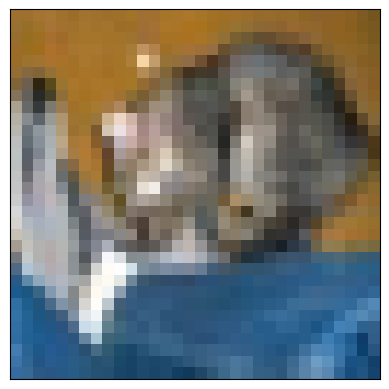

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


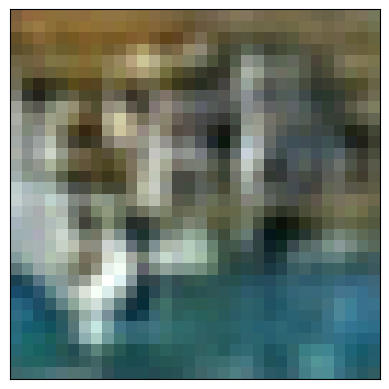

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


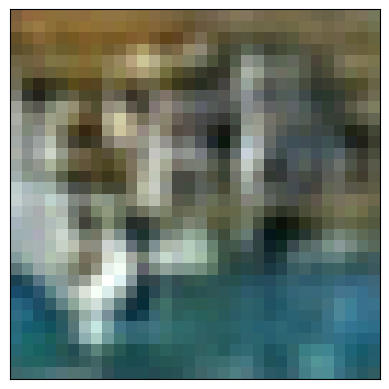

In [58]:
show_image(x + 0.5)
show_image(x_recon.squeeze() + 0.5)
show_image(x_vq_recon.squeeze() + 0.5)

In [60]:
color_decay = 0.9
import pdb
pdb.set_trace()
[color_decay for i in range(3)]

--Return--
None
> /tmp/ipykernel_54990/3185483791.py(3)<module>()
      1 color_decay = 0.9
      2 import pdb
----> 3 pdb.set_trace()
      4 [color_decay for i in range(3)]

0.9
0.9
0.9
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
[0.9, 0.9, 0.9]
